**import libraries**

In [79]:
import pandas as pd
import econml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import boxplot as bp
import math 
import regex as re
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from tqdm import tqdm
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore, K2Score
from pgmpy.inference.CausalInference import CausalInference
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import networkx as nx
import pylab as plt
from IPython.display import Image, display
import dowhy
import graphviz
from dowhy import CausalModel

**load dataset**

In [2]:
data = pd.read_csv('datasets/employee_reviews_sub.csv')

In [3]:
data.dtypes

Unnamed: 0                      int64
company                        object
location                       object
dates                          object
job-title                      object
overall-ratings               float64
work-balance-stars             object
culture-values-stars           object
carrer-opportunities-stars     object
comp-benefit-stars             object
senior-mangemnet-stars         object
helpful-count                   int64
link                           object
dtype: object

In [4]:
data.head()

,Unnamed: 0,company,location,dates,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


### Data Engeneering

In [5]:
#delete the useless columns
data = data.drop(['Unnamed: 0'], axis= 1)
#data = data.drop(['helpful-count'], axis= 1)
data = data.drop(['link'], axis= 1)

**Average ratings for different feature (by company)**. We use these information to fill the missing values in the rating fields.

In [6]:
ratings_comp = data[["company", 'overall-ratings', "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].copy()
ratings_comp.set_index(["company"], inplace=True)
ratings_comp = ratings_comp[~(ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()
avg_company.columns = ['Overall Ratings',"Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]
avg_company = avg_company.transpose()
avg_company

<ipython-input-6-83d9e7432d94>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()


company,amazon,apple,facebook,google,microsoft,netflix
Overall Ratings,3.605707,3.958919,4.518081,4.378480,3.859934,3.497976
Work Balance,3.010915,3.338017,3.904729,4.004104,3.575086,3.210526
Culture Values,3.532292,4.097873,4.515299,4.359208,3.657359,3.514170
Career Opportunities,3.621241,3.419399,4.365090,4.030692,3.710211,3.157895
Company Benefits,3.710779,4.059036,4.573018,4.427552,4.025453,4.257085
Senior Management,3.171875,3.446916,4.260779,3.871877,3.185432,3.192308


In [7]:
companies=pd.unique(data['company'])
#in the following dict are stored the mean values for each comapany and each attribute using the previous dataframe avg_company
ratings_per_company={company: avg_company.loc[:,company].values for company in companies}  #companies are keys whereas values are the different ratings

for index,row in tqdm(data.iterrows()):  #for each row in the dataset  
    company=data.iloc[index,0]  #company name
    for index_y in range(4,10):  #for each column from overall ratings to helpful-count       
        if data.iloc[index,index_y]=='none':
            data.iloc[index,index_y]=round(ratings_per_company.get(company)[index_y-4],1)

67529it [00:44, 1508.31it/s]


In [8]:
#converting dtypes
data['culture-values-stars']=pd.to_numeric(data['culture-values-stars'])
data['work-balance-stars']=pd.to_numeric(data['work-balance-stars'])
data['carrer-opportunities-stars']=pd.to_numeric(data['carrer-opportunities-stars'])
data['comp-benefit-stars']=pd.to_numeric(data['comp-benefit-stars'])
data['senior-mangemnet-stars']=pd.to_numeric(data['senior-mangemnet-stars'])

In [9]:
#get rid of the row without location
data= data[data['location']!='none']
# add a column with the year only
data['year'] = pd.to_datetime(data['dates'], errors='coerce').dt.year
#delete the column with the dates
del data['dates']

In [10]:
data.head()

,company,location,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
1,google,"Mountain View, CA",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013.0
2,google,"New York, NY",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949,2014.0
3,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,2015.0
4,google,"Los Angeles, CA",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,2018.0
5,google,"Mountain View, CA",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,2018.0


In [11]:
#Use the data only with location in California
data_CA=data['location'].filter(regex='CA$',axis=0)
california_loc=pd.unique(list(filter(lambda loc:re.findall(r'CA$',loc),data['location'])))
data_CA=data[data['location'].isin(california_loc)]
#data_CA.head()

Save the processed dataframe into a file

In [12]:
data_CA.to_csv('processed_employee_reviews.csv')

In [13]:
data = pd.read_csv('processed_employee_reviews.csv')
data = data.drop(['Unnamed: 0'], axis= 1)

## Data analysis and visualization

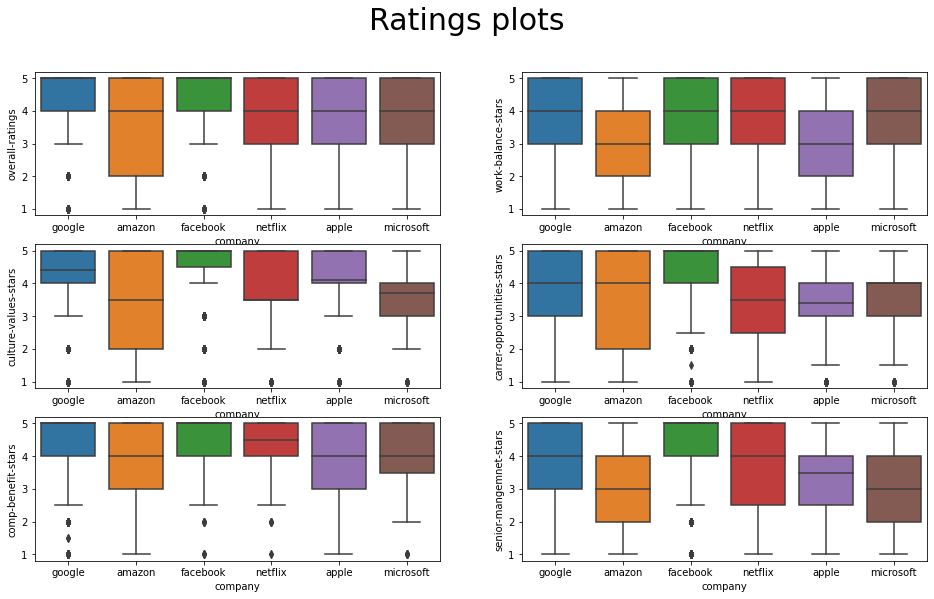

In [14]:
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(16,9))
fig.suptitle('Ratings plots',fontsize=30)
bp(x='company',y='overall-ratings',data=data,ax=axes[0,0])
bp(x='company',y='work-balance-stars',data=data,ax=axes[0,1])
bp(x='company',y='culture-values-stars',data=data,ax=axes[1,0])
bp(x='company',y='carrer-opportunities-stars',data=data,ax=axes[1,1])
bp(x='company',y='comp-benefit-stars',data=data,ax=axes[2,0])
bp(x='company',y='senior-mangemnet-stars',data=data,ax=axes[2,1])
plt.show()

#### Distribution of Reviews by year

/home/eugibaldo/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


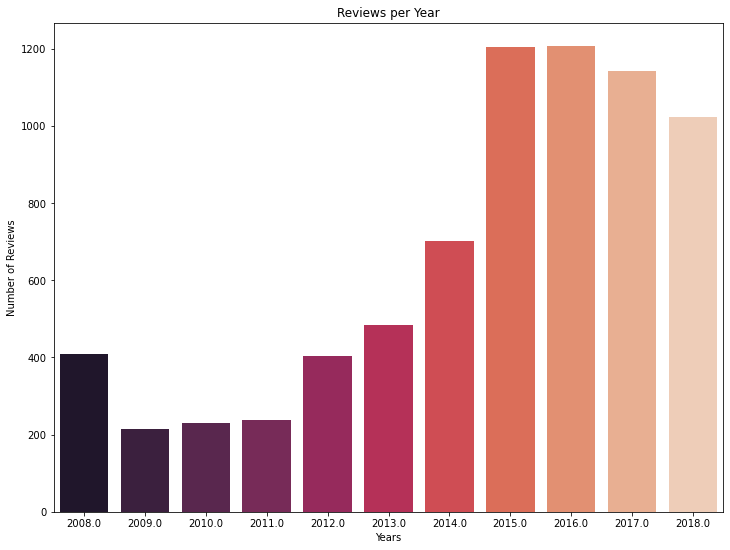

In [15]:
years_count = data_CA['year'].value_counts().sort_index(ascending=True)
years_labels = years_count.index.tolist()
years_index = np.arange(len(years_labels))

plt.figure(figsize=(12, 9))
_ = sns.barplot(years_index, years_count, palette='rocket')
_ = plt.xticks(years_index, years_labels)
_ = plt.xlabel("Years")
_ = plt.ylabel("Number of Reviews")
_ = plt.title("Reviews per Year")

### Which company takes the best treatment for the employees? 

(MAGARI QUESTI PLOT LI METTIAMO TUTTI INSIEME COME E' STATO FATTO PER I BOXPLOT)

In [16]:
def rating_per_company(rating_type, title, color):
    work_ratings = data[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(12, 10), color=color)
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    _ = plt.ylabel('Companies')

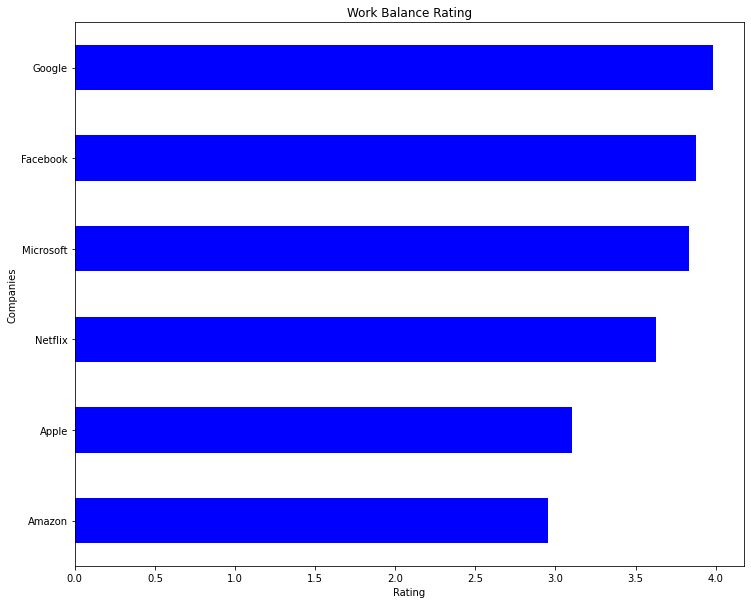

In [17]:
# Which company offers better Work-Life Balance?
rating_per_company('work-balance-stars', "Work Balance", "b")

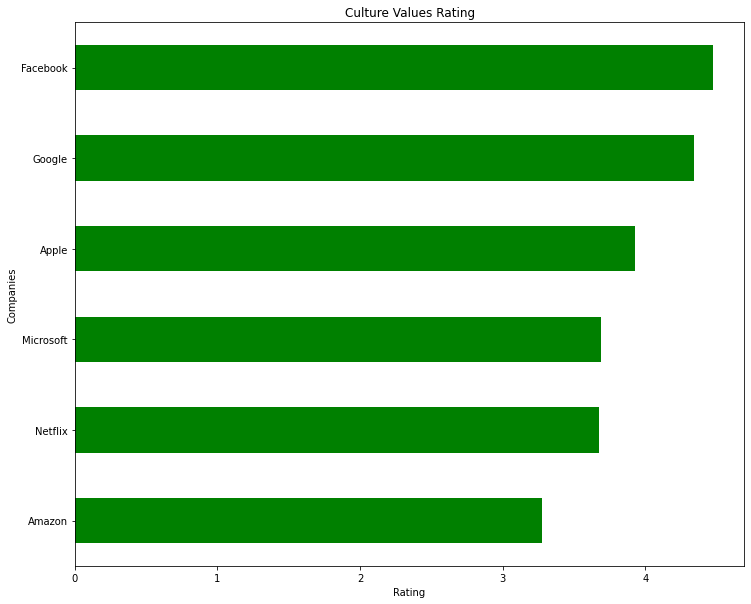

In [18]:
#Which company has better Culture Values?
rating_per_company('culture-values-stars', "Culture Values", "g")

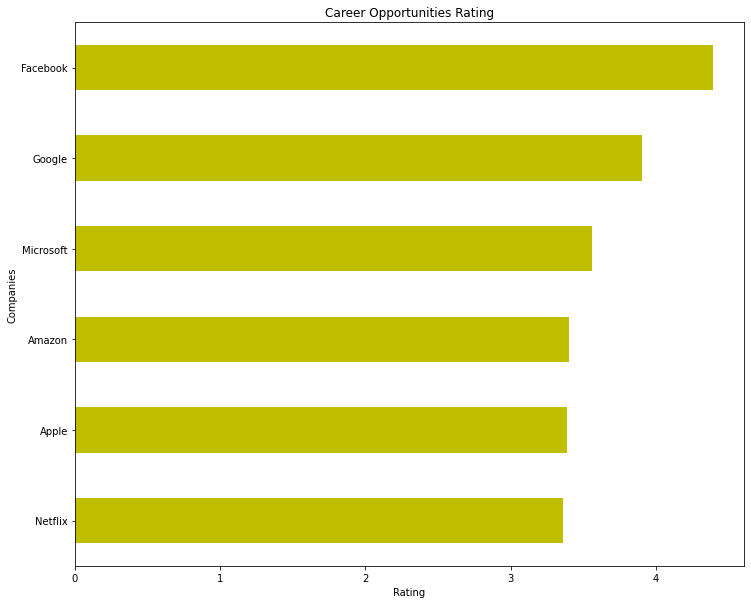

In [19]:
#Which company has better Career Opportunities?
rating_per_company("carrer-opportunities-stars", "Career Opportunities", "y")

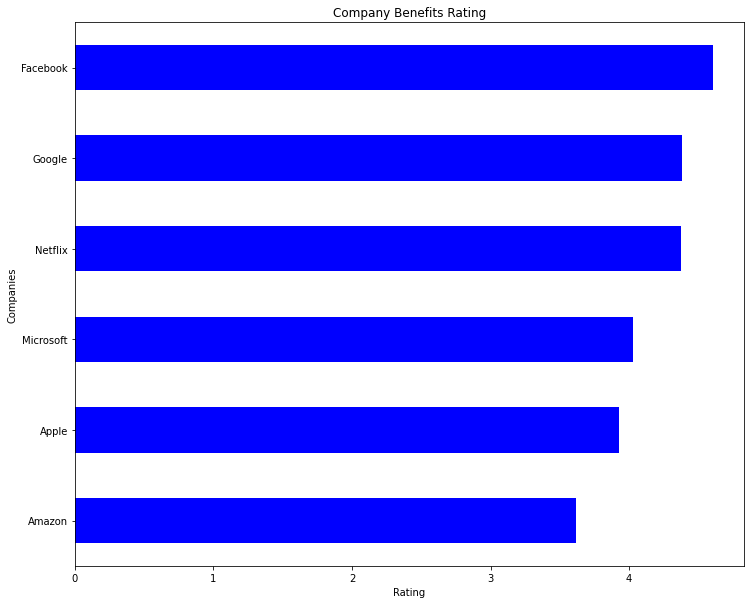

In [20]:
rating_per_company("comp-benefit-stars", "Company Benefits", "b")

## Normalizing the dataframe to explore the correlation between the features

In [21]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
data["Company_code"] =ord_enc.fit_transform(data[["company"]])
data["Job_code"]=ord_enc.fit_transform(data[["job-title"]])
data['Locations_code']=ord_enc.fit_transform(data[["location"]])

In [22]:
#delete the categorical&useless columns
data = data.drop(['company'], axis= 1)
data = data.drop(['location'], axis= 1)
data = data.drop(['job-title'], axis= 1)
data = data.drop(['year'], axis= 1)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #for normalize the values
data_norm= scaler.fit_transform(data)
data_new=pd.DataFrame(data_norm,columns=["overall-ratings","work-balance-stars","culture-values-stars","carrer-opportunities-stars","comp-benefit-stars","senior-mangemnet-stars","helpful-count","Company_code","Job_code","Locations_code"])
data_new.to_csv('normalized_data.csv')

In [24]:
data_new.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Company_code,Job_code,Locations_code
0,0.75,0.25,0.50,0.50,1.00,0.50,1.000000,0.6,0.830282,0.517949
1,1.00,0.25,1.00,1.00,0.75,1.00,0.237822,0.6,0.020287,0.517949
2,1.00,1.00,1.00,1.00,1.00,1.00,0.023400,0.6,0.922316,0.410256
3,1.00,0.75,0.75,0.75,1.00,0.75,0.000478,0.6,0.851559,0.517949
4,1.00,0.75,1.00,0.75,0.75,0.50,0.000000,0.6,0.020287,0.517949


#### Now that we have only encoded data and the values are normalize, we can explore the correlations 

In [25]:
corr_matrix = data_new.corr()
corr_matrix

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Company_code,Job_code,Locations_code
overall-ratings,1.000000,0.603002,0.719810,0.717758,0.573054,0.730413,-0.057725,0.153446,-0.149378,0.015109
work-balance-stars,0.603002,1.000000,0.538494,0.487128,0.427564,0.579817,-0.059352,0.277916,-0.091613,0.089179
culture-values-stars,0.719810,0.538494,1.000000,0.586625,0.473530,0.679739,-0.051175,0.155848,-0.116036,-0.004365
carrer-opportunities-stars,0.717758,0.487128,0.586625,1.000000,0.554727,0.660001,-0.047716,0.107741,-0.117631,0.041321
comp-benefit-stars,0.573054,0.427564,0.473530,0.554727,1.000000,0.500802,-0.005771,0.226806,-0.046077,0.015356
senior-mangemnet-stars,0.730413,0.579817,0.679739,0.660001,0.500802,1.000000,-0.040167,0.142332,-0.134912,-0.025435
helpful-count,-0.057725,-0.059352,-0.051175,-0.047716,-0.005771,-0.040167,1.000000,0.034723,0.025016,-0.024591
Company_code,0.153446,0.277916,0.155848,0.107741,0.226806,0.142332,0.034723,1.000000,0.026377,0.054355
Job_code,-0.149378,-0.091613,-0.116036,-0.117631,-0.046077,-0.134912,0.025016,0.026377,1.000000,0.006841
Locations_code,0.015109,0.089179,-0.004365,0.041321,0.015356,-0.025435,-0.024591,0.054355,0.006841,1.000000


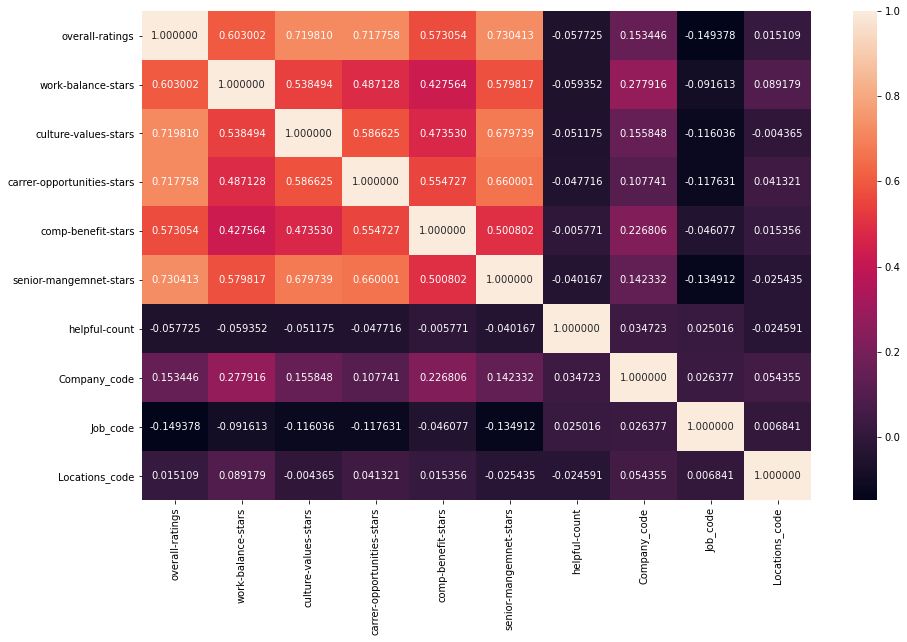

In [26]:
plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, fmt="f");

### From now on our analysis is based on each Company

In [27]:
def corr_matrix(df_company):
    df_company["Job_code"]=ord_enc.fit_transform(df_company[["job-title"]])
    df_company['Locations_code']=ord_enc.fit_transform(df_company[["location"]])

    #delete the categorical&useless columns
    df_company = df_company.drop(['company'], axis= 1)
    df_company = df_company.drop(['location'], axis= 1)
    df_company = df_company.drop(['job-title'], axis= 1)
    df_company = df_company.drop(['year'], axis= 1)

    #Normalize the values
    scaler = MinMaxScaler() 
    df_company_norm= scaler.fit_transform(df_company)
    df_company_new=pd.DataFrame(df_company_norm,columns=['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars',"helpful_count","Job_code","Locations_code"])
    #compute the correlation matrix
    corr_df_company = df_company_new.corr()
    return (corr_df_company)

**Google**

In [28]:
# google=data[data['company']=='google']
# google.to_csv('google.csv')
google = pd.read_csv('google.csv')
del google['Unnamed: 0']

In [29]:
google.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']

In [30]:
google.head()

,company,location,job-title,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,year
0,google,"Mountain View, CA",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013.0
1,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,2015.0
2,google,"Los Angeles, CA",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,2018.0
3,google,"Mountain View, CA",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,2018.0
4,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,4.0,5.0,4.0,4.0,3.0,0,2018.0


In [31]:
fields = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
summary_google = google[fields].describe().transpose()

In [32]:
summary_google

,count,mean,std,min,25%,50%,75%,max
overall_ratings,1971.0,4.268392,0.984917,1.0,4.0,5.0,5.0,5.0
work_balance_stars,1971.0,3.980467,1.081688,1.0,3.0,4.0,5.0,5.0
culture_values_stars,1971.0,4.339016,0.891286,1.0,4.0,4.4,5.0,5.0
carrer_opportunities_stars,1971.0,3.905632,1.098441,1.0,3.0,4.0,5.0,5.0
comp_benefit_stars,1971.0,4.383562,0.831678,1.0,4.0,5.0,5.0,5.0
senior_mangemnet_stars,1971.0,3.837544,1.083682,1.0,3.0,4.0,5.0,5.0


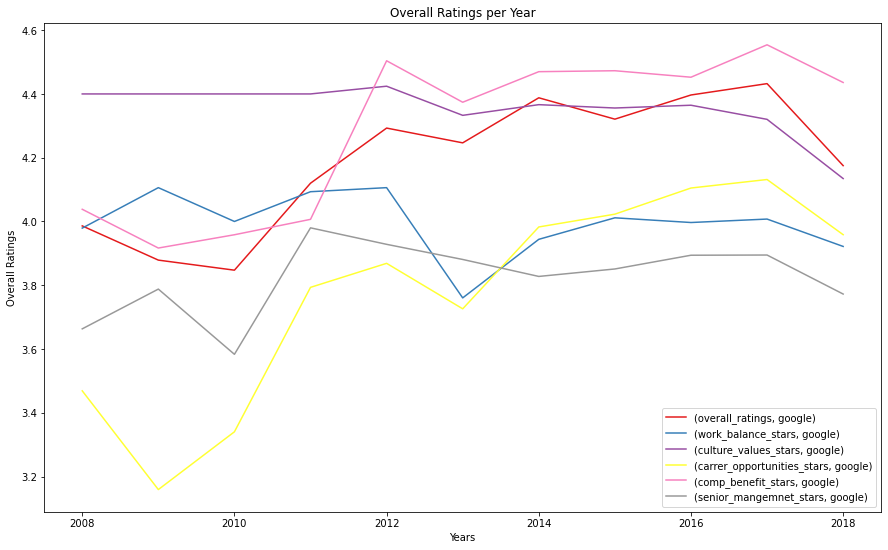

In [33]:
#Ratings over time for Google
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
google.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Google**

In [34]:
corr_matrix(google)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.534754,0.629867,0.681944,0.532440,0.676022,-0.042993,-0.104900,0.040773
work_balance_stars,0.534754,1.000000,0.490533,0.424176,0.366014,0.524520,-0.071789,-0.030793,0.051086
culture_values_stars,0.629867,0.490533,1.000000,0.508046,0.403772,0.619022,-0.053334,-0.086294,-0.000011
carrer_opportunities_stars,0.681944,0.424176,0.508046,1.000000,0.526002,0.617965,-0.044699,-0.055523,0.051904
comp_benefit_stars,0.532440,0.366014,0.403772,0.526002,1.000000,0.474532,-0.004559,0.007304,0.046061
senior_mangemnet_stars,0.676022,0.524520,0.619022,0.617965,0.474532,1.000000,-0.037925,-0.075840,0.011186
helpful_count,-0.042993,-0.071789,-0.053334,-0.044699,-0.004559,-0.037925,1.000000,0.025447,-0.014316
Job_code,-0.104900,-0.030793,-0.086294,-0.055523,0.007304,-0.075840,0.025447,1.000000,-0.019916
Locations_code,0.040773,0.051086,-0.000011,0.051904,0.046061,0.011186,-0.014316,-0.019916,1.000000


**amazon**

In [35]:
# amazon=data[data['company']=='amazon']
# amazon.to_csv('amazon.csv')
amazon = pd.read_csv('amazon.csv')
del amazon['Unnamed: 0']
amazon.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']
summary_amazon = amazon[fields].describe().transpose()

In [36]:
summary_amazon

,count,mean,std,min,25%,50%,75%,max
overall_ratings,1112.0,3.383094,1.381634,1.0,2.0,4.0,5.0,5.0
work_balance_stars,1112.0,2.955486,1.392259,1.0,2.0,3.0,4.0,5.0
culture_values_stars,1112.0,3.272932,1.480724,1.0,2.0,3.5,5.0,5.0
carrer_opportunities_stars,1112.0,3.398741,1.437363,1.0,2.0,4.0,5.0,5.0
comp_benefit_stars,1112.0,3.618435,1.234259,1.0,3.0,4.0,5.0,5.0
senior_mangemnet_stars,1112.0,2.983183,1.416851,1.0,2.0,3.0,4.0,5.0


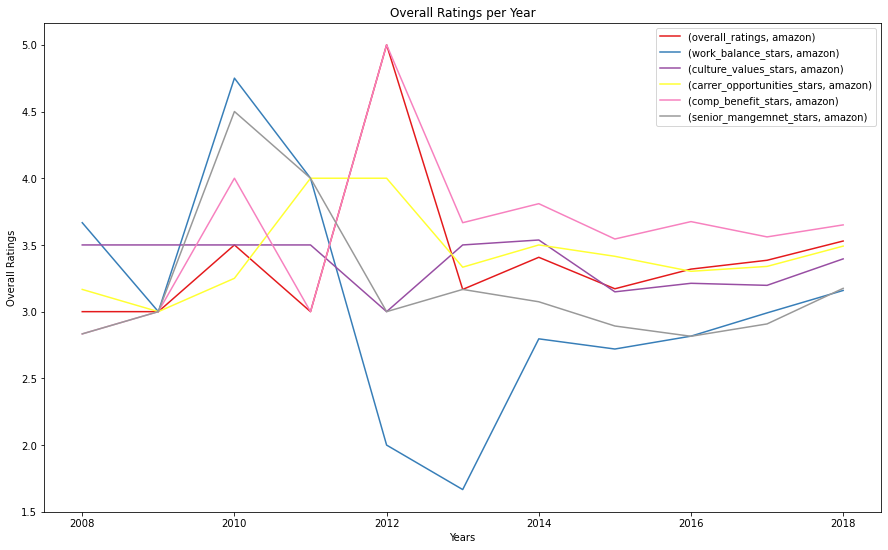

In [37]:
#Ratings over time for Amazon
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
amazon.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Amazon**

In [38]:
corr_matrix(amazon)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.642673,0.798859,0.751848,0.596884,0.741686,-0.298474,-0.232675,0.027843
work_balance_stars,0.642673,1.000000,0.613111,0.530104,0.473803,0.618168,-0.242546,-0.169501,-0.012354
culture_values_stars,0.798859,0.613111,1.000000,0.709928,0.548868,0.775323,-0.252919,-0.177424,0.023865
carrer_opportunities_stars,0.751848,0.530104,0.709928,1.000000,0.584021,0.702227,-0.176339,-0.210544,0.043531
comp_benefit_stars,0.596884,0.473803,0.548868,0.584021,1.000000,0.522702,-0.186785,-0.123374,0.076863
senior_mangemnet_stars,0.741686,0.618168,0.775323,0.702227,0.522702,1.000000,-0.227128,-0.192033,0.007052
helpful_count,-0.298474,-0.242546,-0.252919,-0.176339,-0.186785,-0.227128,1.000000,0.089702,-0.036551
Job_code,-0.232675,-0.169501,-0.177424,-0.210544,-0.123374,-0.192033,0.089702,1.000000,-0.018721
Locations_code,0.027843,-0.012354,0.023865,0.043531,0.076863,0.007052,-0.036551,-0.018721,1.000000


**apple**

In [39]:
# apple=data[data['company']=='apple']
# apple.to_csv('apple.csv')
apple = pd.read_csv('apple.csv')
del apple['Unnamed: 0']
apple.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']
summary_apple = apple[fields].describe().transpose()

In [40]:
summary_apple

,count,mean,std,min,25%,50%,75%,max
overall_ratings,2347.0,3.806562,1.103003,1.0,3.0,4.0,5.0,5.0
work_balance_stars,2347.0,3.102429,1.255796,1.0,2.0,3.0,4.0,5.0
culture_values_stars,2347.0,3.927951,1.095077,1.0,4.0,4.1,5.0,5.0
carrer_opportunities_stars,2347.0,3.388453,1.186216,1.0,3.0,3.4,4.0,5.0
comp_benefit_stars,2347.0,3.929314,0.971193,1.0,3.0,4.0,5.0,5.0
senior_mangemnet_stars,2347.0,3.390839,1.267024,1.0,2.5,3.5,4.0,5.0


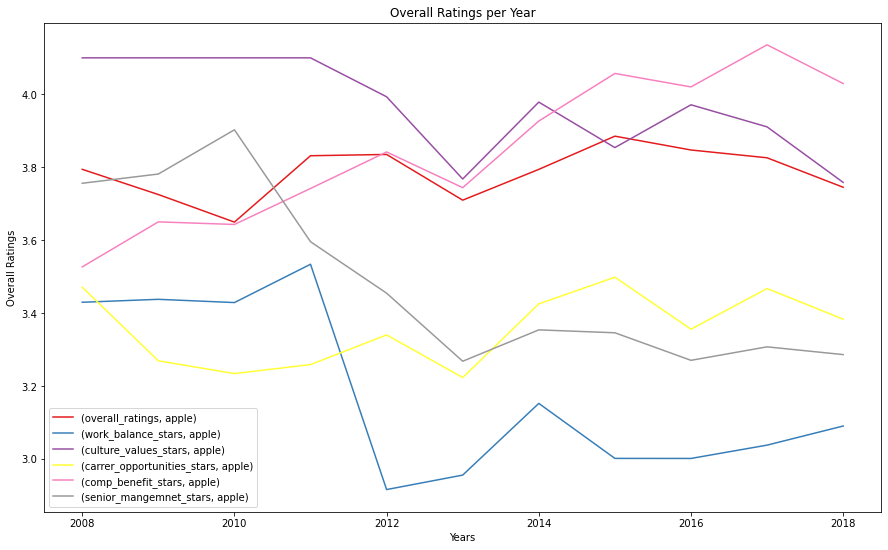

In [41]:
#Ratings over time for Apple
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
apple.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Apple**

In [42]:
corr_matrix(apple)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.552754,0.637333,0.644878,0.518088,0.658798,-0.172964,-0.084436,0.058595
work_balance_stars,0.552754,1.000000,0.460616,0.404448,0.316750,0.538064,-0.146783,-0.045396,0.095678
culture_values_stars,0.637333,0.460616,1.000000,0.475577,0.361552,0.583021,-0.151768,-0.055188,0.089526
carrer_opportunities_stars,0.644878,0.404448,0.475577,1.000000,0.495004,0.588950,-0.099249,-0.052417,-0.000901
comp_benefit_stars,0.518088,0.316750,0.361552,0.495004,1.000000,0.404176,-0.069789,-0.014875,0.031450
senior_mangemnet_stars,0.658798,0.538064,0.583021,0.588950,0.404176,1.000000,-0.098614,-0.059598,-0.004406
helpful_count,-0.172964,-0.146783,-0.151768,-0.099249,-0.069789,-0.098614,1.000000,0.031688,-0.087598
Job_code,-0.084436,-0.045396,-0.055188,-0.052417,-0.014875,-0.059598,0.031688,1.000000,-0.005780
Locations_code,0.058595,0.095678,0.089526,-0.000901,0.031450,-0.004406,-0.087598,-0.005780,1.000000


**microsoft**

In [43]:
# microsoft=data[data['company']=='microsoft']
# microsoft.to_csv('microsoft.csv')
microsoft = pd.read_csv('microsoft.csv')
del microsoft['Unnamed: 0']
microsoft.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']
summary_microsoft = microsoft[fields].describe().transpose()

In [44]:
summary_microsoft

,count,mean,std,min,25%,50%,75%,max
overall_ratings,526.0,3.722433,1.061423,1.0,3.0,4.0,5.0,5.0
work_balance_stars,526.0,3.832319,1.071795,1.0,3.0,4.0,5.0,5.0
culture_values_stars,526.0,3.687833,0.978436,1.0,3.0,3.7,4.0,5.0
carrer_opportunities_stars,526.0,3.560076,1.063079,1.0,3.0,4.0,4.0,5.0
comp_benefit_stars,526.0,4.030418,0.893376,1.0,3.5,4.0,5.0,5.0
senior_mangemnet_stars,526.0,3.148099,1.201660,1.0,2.0,3.0,4.0,5.0


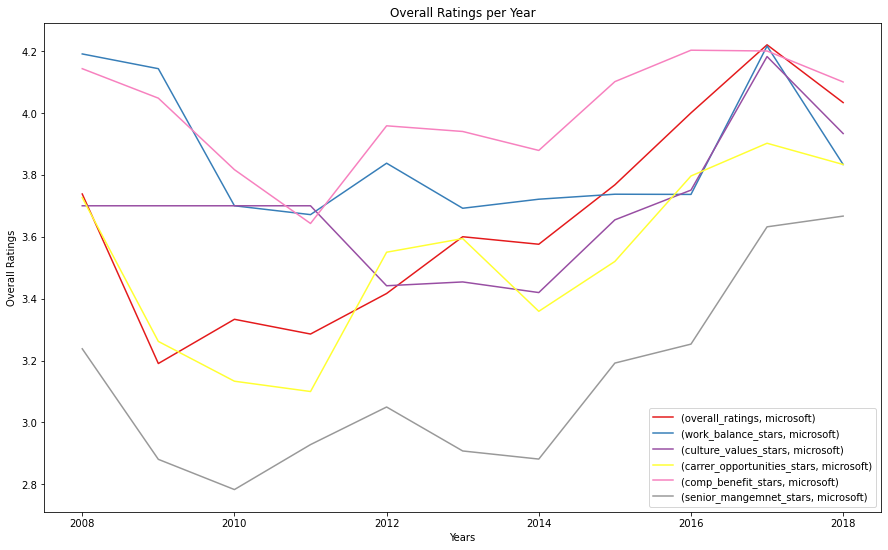

In [45]:
#Ratings over time for Microsoft
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
microsoft.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Microsoft**

In [46]:
corr_matrix(microsoft)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.507352,0.635737,0.649684,0.507082,0.702221,-0.408256,-0.031119,0.060506
work_balance_stars,0.507352,1.000000,0.418678,0.389408,0.406673,0.424974,-0.188886,-0.100016,0.100862
culture_values_stars,0.635737,0.418678,1.000000,0.454501,0.344502,0.615337,-0.218275,-0.067693,-0.014032
carrer_opportunities_stars,0.649684,0.389408,0.454501,1.000000,0.495858,0.574876,-0.305251,-0.011747,0.096801
comp_benefit_stars,0.507082,0.406673,0.344502,0.495858,1.000000,0.359791,-0.236291,0.001499,0.028206
senior_mangemnet_stars,0.702221,0.424974,0.615337,0.574876,0.359791,1.000000,-0.314977,-0.096936,0.052287
helpful_count,-0.408256,-0.188886,-0.218275,-0.305251,-0.236291,-0.314977,1.000000,0.008315,-0.041887
Job_code,-0.031119,-0.100016,-0.067693,-0.011747,0.001499,-0.096936,0.008315,1.000000,-0.014726
Locations_code,0.060506,0.100862,-0.014032,0.096801,0.028206,0.052287,-0.041887,-0.014726,1.000000


**netflix**

In [47]:
# netflix=data[data['company']=='netflix']
# netflix.to_csv('netflix.csv')
netflix = pd.read_csv('netflix.csv')
del netflix['Unnamed: 0']
netflix.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']
summary_netflix = netflix[fields].describe().transpose()

In [48]:
summary_netflix

,count,mean,std,min,25%,50%,75%,max
overall_ratings,321.0,3.744548,1.345192,1.0,3.0,4.0,5.0,5.0
work_balance_stars,321.0,3.628037,1.267635,1.0,3.0,4.0,5.0,5.0
culture_values_stars,321.0,3.677570,1.159039,1.0,3.5,3.5,5.0,5.0
carrer_opportunities_stars,321.0,3.362305,1.300810,1.0,2.5,3.5,4.5,5.0
comp_benefit_stars,321.0,4.376636,0.788461,1.0,4.0,4.5,5.0,5.0
senior_mangemnet_stars,321.0,3.595327,1.431567,1.0,2.5,4.0,5.0,5.0


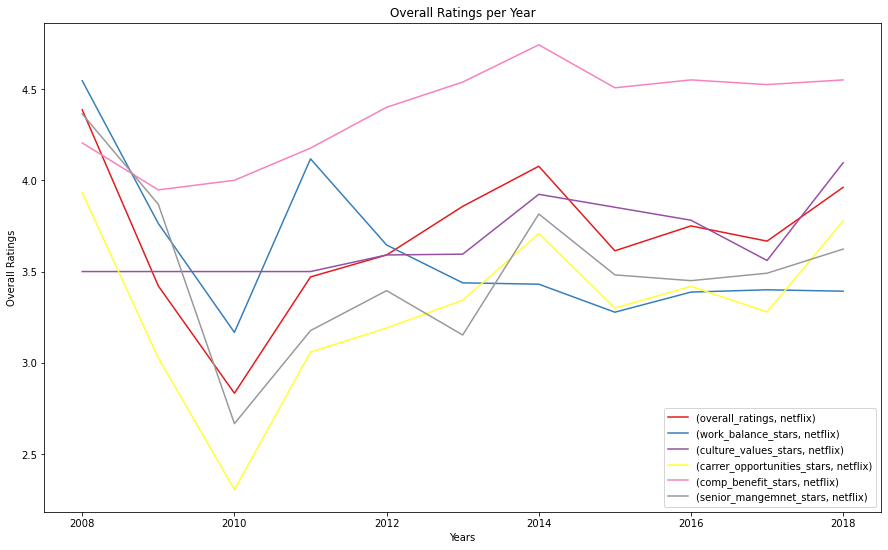

In [49]:
#Ratings over time for Netflix
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
netflix.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Netflix**

In [50]:
corr_matrix(netflix)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.680999,0.626473,0.800626,0.517923,0.810433,-0.512204,-0.348690,0.023851
work_balance_stars,0.680999,1.000000,0.463042,0.550973,0.310474,0.682019,-0.402915,-0.272429,-0.027971
culture_values_stars,0.626473,0.463042,1.000000,0.571339,0.405328,0.603752,-0.427046,-0.235981,-0.033759
carrer_opportunities_stars,0.800626,0.550973,0.571339,1.000000,0.464276,0.718294,-0.400537,-0.312944,0.086992
comp_benefit_stars,0.517923,0.310474,0.405328,0.464276,1.000000,0.433990,-0.120701,-0.125396,-0.044354
senior_mangemnet_stars,0.810433,0.682019,0.603752,0.718294,0.433990,1.000000,-0.455554,-0.360971,0.017529
helpful_count,-0.512204,-0.402915,-0.427046,-0.400537,-0.120701,-0.455554,1.000000,0.266848,-0.093875
Job_code,-0.348690,-0.272429,-0.235981,-0.312944,-0.125396,-0.360971,0.266848,1.000000,0.083848
Locations_code,0.023851,-0.027971,-0.033759,0.086992,-0.044354,0.017529,-0.093875,0.083848,1.000000


**facebook**

In [51]:
# facebook=data[data['company']=='facebook']
# facebook.to_csv('facebook.csv')
facebook = pd.read_csv('facebook.csv')
del facebook['Unnamed: 0']
facebook.columns= ['company','location','job-title','overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count','year']

summary_facebook = facebook[fields].describe().transpose()

In [52]:
summary_facebook

,count,mean,std,min,25%,50%,75%,max
overall_ratings,984.0,4.506098,0.963190,1.0,4.0,5.0,5.0,5.0
work_balance_stars,984.0,3.877744,1.174726,1.0,3.0,4.0,5.0,5.0
culture_values_stars,984.0,4.470020,0.968405,1.0,4.5,5.0,5.0,5.0
carrer_opportunities_stars,984.0,4.390142,0.972477,1.0,4.0,5.0,5.0,5.0
comp_benefit_stars,984.0,4.602439,0.680086,1.0,4.0,5.0,5.0,5.0
senior_mangemnet_stars,984.0,4.269614,1.071247,1.0,4.0,5.0,5.0,5.0


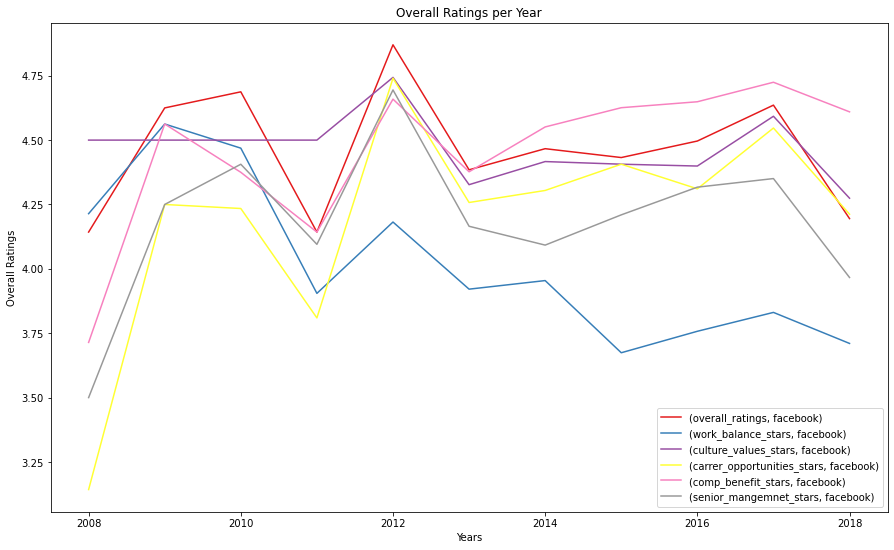

In [53]:
#Ratings over time for Facebook
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall_ratings','work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']
facebook.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Facebook**

In [54]:
corr_fb = corr_matrix(facebook)

In [55]:
corr_fb

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,Job_code,Locations_code
overall_ratings,1.000000,0.604796,0.778088,0.780238,0.441339,0.772309,-0.206851,-0.268972,-0.063440
work_balance_stars,0.604796,1.000000,0.563945,0.525804,0.350925,0.599682,-0.158623,-0.216609,-0.001668
culture_values_stars,0.778088,0.563945,1.000000,0.690051,0.370360,0.707765,-0.169488,-0.240149,-0.049880
carrer_opportunities_stars,0.780238,0.525804,0.690051,1.000000,0.517276,0.695116,-0.177462,-0.207805,-0.063515
comp_benefit_stars,0.441339,0.350925,0.370360,0.517276,1.000000,0.476689,-0.074236,-0.071012,-0.116213
senior_mangemnet_stars,0.772309,0.599682,0.707765,0.695116,0.476689,1.000000,-0.159814,-0.261915,-0.049443
helpful_count,-0.206851,-0.158623,-0.169488,-0.177462,-0.074236,-0.159814,1.000000,0.049493,-0.001566
Job_code,-0.268972,-0.216609,-0.240149,-0.207805,-0.071012,-0.261915,0.049493,1.000000,-0.002573
Locations_code,-0.063440,-0.001668,-0.049880,-0.063515,-0.116213,-0.049443,-0.001566,-0.002573,1.000000


### facebook

#### probabilistic and graphical models

In [94]:
facebook.head()

,company,location,job-title,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,year,Job_code,Locations_code,work_balance,comp_benefit
0,facebook,"Menlo Park, CA",Current Employee - Product Operations,5.0,4,4,5,5,4,0,2018.0,101,6,1,1
1,facebook,"Menlo Park, CA",Current Employee - Anonymous Employee,5.0,5,5,5,5,5,294,2017.0,6,6,1,1
2,facebook,"Menlo Park, CA",Current Employee - Site Selection Program Manager,5.0,4,5,4,5,5,363,2016.0,141,6,1,1
3,facebook,"Menlo Park, CA",Current Employee - Anonymous Employee,5.0,4,5,5,5,5,6,2018.0,6,6,1,1
4,facebook,"Menlo Park, CA",Current Employee - Product Manager,2.0,1,1,2,4,1,52,2018.0,99,6,0,1


In [95]:
subset=['work_balance_stars','comp_benefit_stars','senior_mangemnet_stars','carrer_opportunities_stars','culture_values_stars','Job_code','Locations_code']
facebook[subset]=facebook[subset].astype(int)
df_train_test_fb=facebook[['work_balance_stars','culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars']]
df_train_fb = df_train_test_fb.sample(n=len(df_train_test_fb), random_state=1618)[0:int(len(df_train_test_fb)*0.7)]
df_test_fb = df_train_test_fb.sample(n=len(df_train_test_fb), random_state=1618)[int(len(df_train_test_fb)*0.7):]

df_train_fb.head()

,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars
523,5,5,5,5,5
318,3,4,4,4,4
692,5,4,4,4,4
551,5,5,5,5,5
226,4,5,5,5,5





Finding Elimination Order: : 100%|██████████| 3/3 [00:35<00:00, 11.91s/it]



  0%|          | 6/1000000 [00:00<9:13:53, 30.09it/s] 



[('culture_values_stars', 'carrer_opportunities_stars'), ('culture_values_stars', 'senior_mangemnet_stars'), ('culture_values_stars', 'work_balance_stars'), ('carrer_opportunities_stars', 'comp_benefit_stars'), ('carrer_opportunities_stars', 'senior_mangemnet_stars'), ('senior_mangemnet_stars', 'work_balance_stars')]


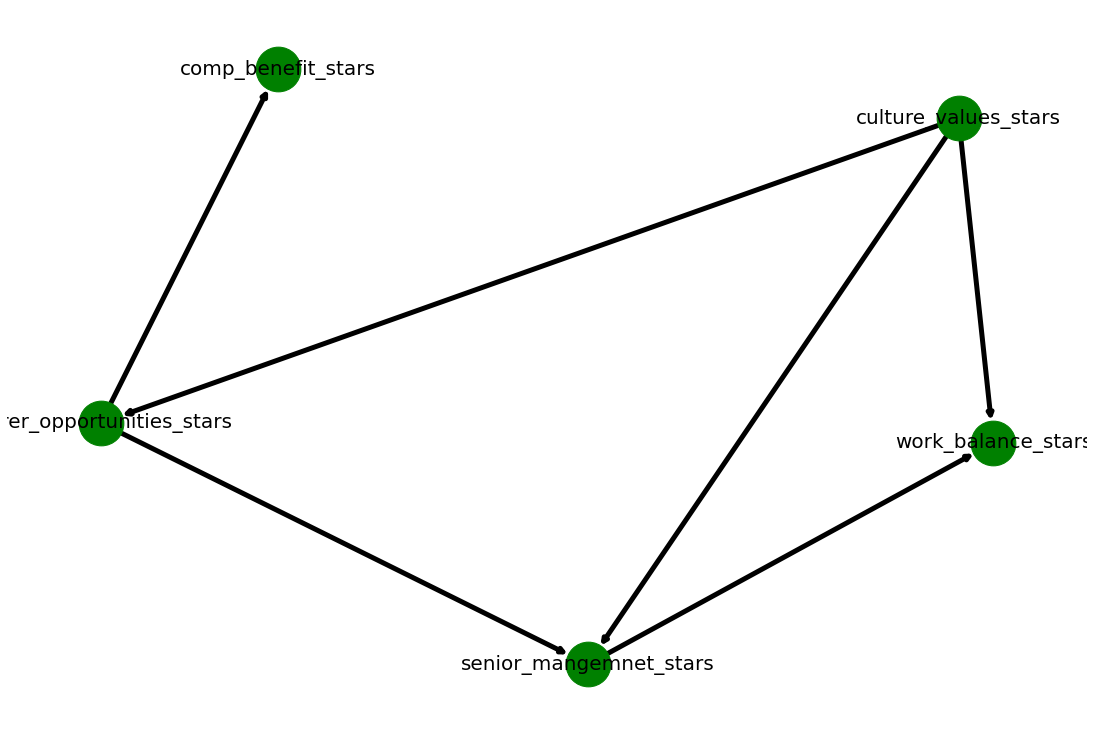

In [96]:
hc = HillClimbSearch(df_train_fb, scoring_method=K2Score(df_train_fb))  #use the training set to build the model
#The score to be optimized during structure estimation.  
#  Supported structure scores: k2score, bdeuscore, bicscore.
best_model = hc.estimate()
print(best_model)
edges = list(best_model.edges())
print(edges)
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))


nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=2000,
        node_color="green", width = 5, font_size = 20)
plt.show()

In [97]:
model.fit(df_train_fb, estimator=MaximumLikelihoodEstimator)
infer = VariableElimination(model)

In [98]:
#focus on the relation between culture_values_stars and work_balance

In [99]:
print(infer.query(variables=['work_balance_stars', 'culture_values_stars'], joint= True))

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 556.74it/s][A

Eliminating: carrer_opportunities_stars: 100%|██████████| 3/3 [00:00<00:00, 268.71it/s]

+-------------------------+-----------------------+------------------------------------------------+
| culture_values_stars    | work_balance_stars    |   phi(culture_values_stars,work_balance_stars) |
+=========================+=======================+================================================+
| culture_values_stars(1) | work_balance_stars(1) |                                         0.0218 |
+-------------------------+-----------------------+------------------------------------------------+
| culture_values_stars(1) | work_balance_stars(2) |                                         0.0015 |
+-------------------------+-----------------------+------------------------------------------------+
| culture_values_stars(1) | work_balance_stars(3) |                                         0.0073 |
+-------------------------+-----------------------+------------------------------------------------+
| culture_values_stars(1) | work_balance_stars(4) |                                        

In [100]:
for i in range(1,6):

    print(infer.query(variables=['work_balance_stars'], evidence={'culture_values_stars': i}))

Eliminating: carrer_opportunities_stars: 100%|██████████| 3/3 [00:00<00:00, 309.44it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: senior_mangemnet_stars:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: comp_benefit_stars:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: carrer_opportunities_stars: 100%|██████████| 3/3 [00:00<00:00, 309.65it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


Eliminating: senior_mangemnet_stars:   0%|          | 0/3 [00:00<?, ?it/s]


Eliminating: comp_benefit_stars:   0%|          | 0/3 [00:00<?, ?it/s]    


Eliminating: carrer_opportunities_stars: 100%|██████████| 3/3 [00:00<00:00, 585.22it/s]



  0%|          | 0/3 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]



  0%|          | 0/3 [00:00<?, ?it/s]



Eliminating: senio

+-----------------------+---------------------------+
| work_balance_stars    |   phi(work_balance_stars) |
+=======================+===========================+
| work_balance_stars(1) |                    0.6522 |
+-----------------------+---------------------------+
| work_balance_stars(2) |                    0.0435 |
+-----------------------+---------------------------+
| work_balance_stars(3) |                    0.2174 |
+-----------------------+---------------------------+
| work_balance_stars(4) |                    0.0870 |
+-----------------------+---------------------------+
| work_balance_stars(5) |                    0.0000 |
+-----------------------+---------------------------+
+-----------------------+---------------------------+
| work_balance_stars    |   phi(work_balance_stars) |
+=======================+===========================+
| work_balance_stars(1) |                    0.3043 |
+-----------------------+---------------------------+
| work_balance_stars(2) |   

In [101]:
inference = CausalInference(model=model)

inference.estimate_ate("culture_values_stars", "work_balance_stars", data=df_test_fb, estimator_type="linear")


Finding Elimination Order: : 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


In [65]:
causal_graph_facebook = """
digraph {
work_balance_stars;
carrer_opportunities_stars;
comp_benefit_stars;
senior_mangemnet_stars;
carrer_opportunities_stars -> comp_benefit_stars; 
carrer_opportunities_stars -> senior_mangemnet_stars; 

culture_values_stars -> senior_mangemnet_stars;
culture_values_stars -> carrer_opportunities_stars
culture_values_stars -> work_balance_stars

senior_mangemnet_stars -> work_balance_stars;

}
"""

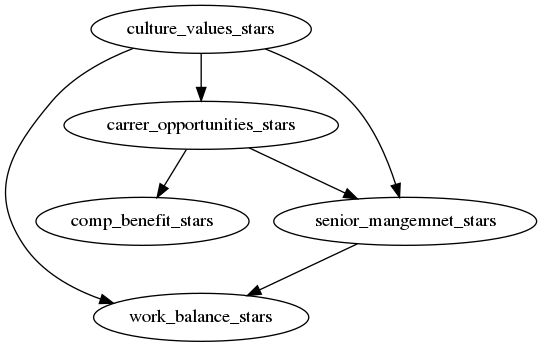

In [102]:
#here we use the DAG schema obtained with Hillclimsearch algorithm


outcome='work_balance_stars'
treatment='culture_values_stars'

model_fb= CausalModel(
        data = df_test_fb,
        graph=causal_graph_facebook.replace("\n", " "),
        treatment=treatment,
        outcome=outcome
)
model_fb.view_model()
display(Image(filename='causal_model.png'))

In [103]:
estimands = model_fb.identify_effect()


In [104]:
estimate = model_fb.estimate_effect(estimands,
                                 method_name = 'backdoor.linear_regression',
                                 test_significance=True, confidence_intervals=True
                                
                                
                                )
                                 
                                 
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                            
──────────────────────(Expectation(work_balance_stars))
d[cultureᵥₐₗᵤₑₛ ₛₜₐᵣₛ]                                 
Estimand assumption 1, Unconfoundedness: If U→{culture_values_stars} and U→work_balance_stars then P(work_balance_stars|culture_values_stars,,U) = P(work_balance_stars|culture_values_stars,)

## Realized estimand
b: work_balance_stars~culture_values_stars
Target units: ate

## Estimate
Mean value: 0.6796463506395782
p-value: [1.8636367e-25]
95.0% confidence interval: [[0.56314261 0.79615009]]



In [105]:
#refutel = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
#print(refutel)

In [106]:
refutel = model_fb.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.6796463506395782
New effect:0.678696623480598



In [107]:
refutel = model_fb.refute_estimate(estimands,estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.6796463506395782
New effect:0.6806310363111902
p value:0.45999999999999996



#### Classification

In [109]:
facebook['work_balance']=list(map(lambda x: 1 if x>3.5 else 0,facebook['work_balance_stars']))
facebook['comp_benefit']=list(map(lambda x: 1 if x>3.5 else 0,facebook['comp_benefit_stars']))
facebook.dtypes

company                        object
location                       object
job-title                      object
overall_ratings               float64
work_balance_stars              int64
culture_values_stars            int64
carrer_opportunities_stars      int64
comp_benefit_stars              int64
senior_mangemnet_stars          int64
helpful_count                   int64
year                          float64
Job_code                        int64
Locations_code                  int64
work_balance                    int64
comp_benefit                    int64
dtype: object

In [110]:
fb_jobs=facebook[facebook['Job_code']!=17.0]
fb_jobs['Job_code']=fb_jobs['Job_code'].astype('str')
fb_jobs[['comp_benefit_stars','senior_mangemnet_stars','carrer_opportunities_stars','culture_values_stars']]=fb_jobs[['comp_benefit_stars','senior_mangemnet_stars','carrer_opportunities_stars','culture_values_stars']].astype('int')

X = fb_jobs[['comp_benefit_stars']]
y = fb_jobs['work_balance'].astype('int')

# split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
X_train_fb, X_test_fb, y_train_fb, y_test_fb = train_test_split(X, y, test_size=0.30, random_state=42)



<ipython-input-110-a18799d0fca8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb_jobs['Job_code']=fb_jobs['Job_code'].astype('str')
/home/eugibaldo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [111]:
model_NB=GaussianNB()
model_NB.fit(X_train_fb,y_train_fb)
print(model_NB.score(X_test_fb,y_test_fb))


0.7016949152542373


In [112]:
model_SVC=SVC()
model_SVC.fit(X_train_fb,y_train_fb)
print(model_SVC.score(X_test_fb,y_test_fb))

0.7016949152542373
